In [2]:
from run_dnerf import config_parser, create_nerf
import matplotlib.pyplot as plt
import torch
from load_blender import pose_spherical
from run_dnerf import render_path
from run_dnerf_helpers import to8b
import imageio

In [6]:
# set cuda
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get config file
config_file = "configs/yong_kati.txt"
parser = config_parser()
args = parser.parse_args(f'--config {config_file}')

# set render params
hwf = [400, 400, 555.555]
_, render_kwargs_test, _, _, _ = create_nerf(args)
render_kwargs_test.update({'near' : 2., 'far' : 6.})


NeRF type selected: direct_temporal
Found ckpts ['./logs/yong_kati_test/100000.tar', './logs/yong_kati_test/200000.tar', './logs/yong_kati_test/300000.tar', './logs/yong_kati_test/400000.tar', './logs/yong_kati_test/500000.tar', './logs/yong_kati_test/600000.tar', './logs/yong_kati_test/700000.tar']
Reloading from ./logs/yong_kati_test/700000.tar


## Generate Frame

In [7]:
def generate_img(time, azimuth, elevation):
    assert 0. <= time <= 1.
    assert -180 <= azimuth <= 180
    assert -180 <= elevation <= 180
    
    render_poses = torch.unsqueeze(pose_spherical(azimuth, elevation, 4.0), 0).to(device)
    render_times = torch.Tensor([time]).to(device)

    with torch.no_grad():
            rgbs, _ = render_path(render_poses, render_times, hwf, args.chunk, render_kwargs_test, render_factor=args.render_factor)
    rgbs = to8b(rgbs)
    return rgbs[0]

100%|██████████| 1/1 [00:05<00:00,  5.96s/it]


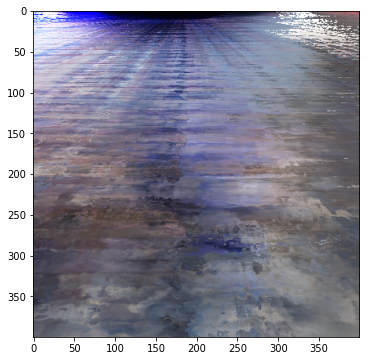

In [8]:
# genearte
time = .5  # in [0,1]
azimuth = 180  # in [-180,180]
elevation = -20  # in [-180,180]
img = generate_img(time, azimuth, elevation)

# display
plt.figure(2, figsize=(20,6))
plt.imshow(img)
plt.show()

In [ ]:
rgbs = []
render_times = torch.linspace(0., 1.)
for idx, time in enumerate(render_times):
    print(f"Image {idx+1} out of {len(render_times)}")
    time = time  # in [0,1]
    azimuth = 180  # in [-180,180]
    elevation = -20  # in [-180,180]
    img = generate_img(time, azimuth, elevation)
    rgbs.append(img)

writer = imageio.get_writer('some_file.mp4', fps=30)
for img in rgbs:
    writer.append_data(img)
writer.close()
